# Creación de modelos

En este notebook vamos a implementar diferentes modelos para el sistema TEP. Cada uno de los modelos tiene un objetivo específico. Los objetivos que vamos a plantear son: detectar fallos presentes, anticipar fallos futuros, clasificar el tipo de fallo y detectar anomalías usando enfoques no supervisados.

Durante el notebook hemos detallado el proceso de creación de los modelos y tambien la evaluación de cada modelo mediante algunas métricas como recall, precisión y F1-score.

In [1]:
!pip install bentoml==1.4.12

import os
import joblib
import pandas as pd
import bentoml
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

## Selección de variables

Vamos a realizar un analisis para seleccionar el número de varaibles optimo para entrenar nuestros modelos, ya que usar todas es demasiado costoso. Para ello, en vez de utilizar todas las variables disponibles, se selecciona un subconjunto que acumula el 75 % de la importancia total.

Calculando importancia de variables...


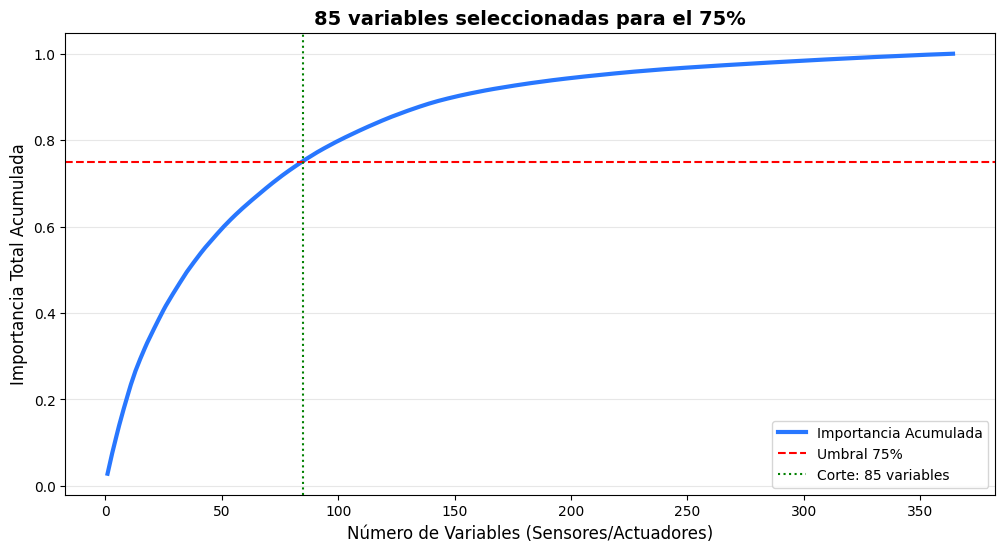

--- CONCLUSIÓN DE SELECCIÓN DE VARIABLES ---
Variables totales disponibles: 364
Variables seleccionadas (75% importancia): 85
Reducción de dimensionalidad: 76.65%


In [4]:
# ==============================================================================
# SELECCIÓN DINÁMICA DE VARIABLES 
# ==============================================================================

# 1. CARGA DE DATOS PARA MODELADO
df_model = pd.read_csv("DatasetProcesado/TEP_features_train.csv")

# Definir columnas que NO son predictoras
cols_no_deseadas = [
    'faultNumber', 'simulationRun', 'sample', 
    'fault_present', 'time_since_fault', 'fault_stage'
]

feature_columns = [c for c in df_model.columns if c not in cols_no_deseadas]

X = df_model[feature_columns]
y = df_model['fault_present']

# División entrenamiento/test inicial
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. ANÁLISIS DE IMPORTANCIA ACUMULADA
print("Calculando importancia de variables...")
clf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_selector.fit(X_train, y_train)

# Calcular importancia y ordenarla
importancias = pd.Series(clf_selector.feature_importances_, index=feature_columns).sort_values(ascending=False)
importancia_acumulada = importancias.cumsum()

# 3. SELECCIÓN AUTOMÁTICA SEGÚN UMBRAL (75%)
umbral_target = 0.75
n_optimo = (importancia_acumulada < umbral_target).sum() + 1
top_features = importancias.head(n_optimo).index.tolist()

# 4. VISUALIZACIÓN DEL CRITERIO DE OPTIMIZACIÓN
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(importancias) + 1), importancia_acumulada, color='#2877FF', linewidth=3, label='Importancia Acumulada')
plt.axhline(y=umbral_target, color='r', linestyle='--', label=f'Umbral {int(umbral_target*100)}%')
plt.axvline(x=n_optimo, color='g', linestyle=':', label=f'Corte: {n_optimo} variables')

plt.title(f'{n_optimo} variables seleccionadas para el {int(umbral_target*100)}%', fontsize=14, fontweight='bold')
plt.xlabel('Número de Variables (Sensores/Actuadores)', fontsize=12)
plt.ylabel('Importancia Total Acumulada', fontsize=12)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"--- CONCLUSIÓN DE SELECCIÓN DE VARIABLES ---")
print(f"Variables totales disponibles: {len(feature_columns)}")
print(f"Variables seleccionadas (75% importancia): {n_optimo}")
print(f"Reducción de dimensionalidad: {((len(feature_columns)-n_optimo)/len(feature_columns))*100:.2f}%")

A continuación las guardardamos para garantizar la consistencia entre las distintas fases del proyecto, durante los entrenamientos y las llamadas a BentoML.

In [6]:
import joblib
import json

# Guardar como JSON
with open("DatasetProcesado/top_features.json", "w") as f:
    json.dump(top_features, f)

joblib.dump(top_features, "DatasetProcesado/top_features.pkl")

print(f"Lista de {len(top_features)} variables guardada correctamente.")

Lista de 85 variables guardada correctamente.


# Modelo 1: Clasificación binaria

El objetivo de este primer modelo implementado es clasificar cada simulacro del dataset TEP como:
- 0 → No ocurrió ningún fallo
- 1 → Ocurrió un fallo
Es decir que se busca detectar si ya ha ocurrido un fallo basándose en las mediciones y variables de control de cada simulacro.


Este modelo de clasificación binaria está entrenado con un conjunto de datos independiente del test para evitar sobreajuste, y solo con las top_features seleccionadas, reduciendo ruido e incrementando interpretabilidad ademas de optimizar la ejecución. El escalado se aplica únicamente al entrenamiento para prevenir filtrado de información del test. En cuanto a la elección del modelo, Random Forest, hay que mencionar que la decisión se basa en que con profundidad y número de árboles controlados ofrece un balance entre precisión, ligereza y robustez frente a datos complejos. Seguido al entrenamiento del modelo, se registra la importancia de cada variable para facilitar la comprensión del modelo, y, por último, se guardan métricas asegurando una evaluación confiable y lista para producción con BentoML, manteniendo reproducibilidad y trazabilidad.

Las métricas usadas en este modelo describen lo siguiente: 
- Accuracy: indica la proporción de predicciones correctas sobre el total, ofreciendo una visión general del desempeño del modelo.
- Precision: mide la exactitud de las predicciones positivas; es decir, de todas las veces que el modelo predijo un fallo, cuántas fueron correctas.
- Recall: mide la capacidad del modelo de detectar todos los fallos reales, importante para minimizar falsos negativos.
- F1-score: combina precision y recall en un solo valor balanceado, útil cuando se requiere un compromiso entre ambos.
- ROC-AUC: evalúa la capacidad del modelo de distinguir entre las dos clases en diferentes umbrales de decisión; un valor cercano a 1 indica excelente discriminación.
- Matriz de confusión: muestra los aciertos y errores clasificados por clase, facilitando la identificación de patrones de error.
- Classification report: resume todas estas métricas por clase, ofreciendo un análisis detallado del rendimiento en cada categoría.

En conjunto, estas métricas permiten evaluar de manera completa tanto la exactitud general como la capacidad del modelo para identificar correctamente fallos, crucial en un problema binario de detección.

### Entrenamiento

In [7]:
def entrenar_modelo1():
    # 1. Cargar datasets (Entrenamiento y Test independiente)
    df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
    df_test_real = pd.read_csv("DatasetProcesado/TEP_features_test.csv")
    target_col = 'fault_present'

    # 2. Selección de variables optimizadas (top_features ya debe existir en tu sesión)
    X_train_full = df_train[top_features]
    y_train_full = df_train[target_col]
    X_test_real = df_test_real[top_features]
    y_test_real = df_test_real[target_col]

    # 3. Escalado Profesional (Fit solo en Train)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_test_scaled = scaler.transform(X_test_real) # Transformación limpia en Test

    # 4. Entrenamiento del Modelo (Optimizado: 60 árboles para ligereza)
    clf = RandomForestClassifier(
        n_estimators=60, 
        max_depth=12, 
        random_state=42, 
        n_jobs=-1
    )
    
    print("Entrenando Modelo 1 (Binario)...")
    clf.fit(X_train_scaled, y_train_full)

    # 5. Generar ranking de importancia
    ranking = pd.DataFrame({
        'feature': top_features,
        'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    os.makedirs("modelos", exist_ok=True)
    ranking.to_csv("modelos/feature_importance_ranking_model1.csv", index=False)

    # 6. Registro en BentoML con metadatos para el servicio
    bentoml.sklearn.save_model(
        "tep_model1",
        clf,
        metadata={
            "top_features": top_features,
            "scaler_mean": scaler.mean_.tolist(),
            "scaler_scale": scaler.scale_.tolist(),
            "n_features": len(top_features),
            "threshold": "75% importance",
            "trained_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    )

    # 7. Evaluación
    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(y_test_real, y_pred),
        'precision': precision_score(y_test_real, y_pred, average='weighted'),
        'recall': recall_score(y_test_real, y_pred, average='weighted'),
        'f1_score': f1_score(y_test_real, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test_real, y_proba),
        'confusion_matrix': confusion_matrix(y_test_real, y_pred),
        'classification_report': classification_report(y_test_real, y_pred, digits=4)
    }

    return clf, ranking, metrics, X_test_scaled, y_test_real

### Evaluación del modelo

In [8]:
# Ejecución
clf, ranking, metrics, X_test, y_test = entrenar_modelo1()

# Visualización de resultados
print("=== RESULTADOS MODELO 1 (BINARIO) ===")
print("Confusion Matrix:")
print(metrics["confusion_matrix"])

print(f"\nAccuracy:  {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1-score:  {metrics['f1_score']:.4f}")
print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")

print("\nClassification Report:")
print(metrics["classification_report"])

Entrenando Modelo 1 (Binario)...
=== RESULTADOS MODELO 1 (BINARIO) ===
Confusion Matrix:
[[ 18060   1140]
 [   599 191401]]

Accuracy:  0.9918
Precision: 0.9917
Recall:    0.9918
F1-score:  0.9917
ROC-AUC:   0.9992

Classification Report:
              precision    recall  f1-score   support

           0     0.9679    0.9406    0.9541     19200
           1     0.9941    0.9969    0.9955    192000

    accuracy                         0.9918    211200
   macro avg     0.9810    0.9688    0.9748    211200
weighted avg     0.9917    0.9918    0.9917    211200



Como muestra la matriz de confusión, hay un desequilibrio en la proporción del dataset: la clase 1 (fallo) tiene 192,000 muestras, mientras que la clase Normal (0) cuenta con 19,200 muestras. Esto es un desequilibrio de 10:1. Cabe aclarar que este desequilibrio no es un error en la reducción, sino una decisión intencionada con el fin de respetar la proporción del dataset original.

### Conclusión

Por lo que muestran las metricas, la exactitud obtenida es del 99.18%, lo que indica que el modelo distingue casi perfectamente simulacros con fallo de los que no tienen fallo. A pesar de lo mencionado del desequilibrio entre clases, el modelo es casi perfecto detectando correctamente el 99.69% de los fallos (solo 599 falsos negativos) y el 94.06% de los estados normales (1140 falsos positivos).

Como conclusión sobre el desempeño, se puede afirmar que el modelo está cumpliendo el objetivo inicial: identificar si ha ocurrido un fallo en cada simulación.

# Modelo 2: Predicción de fallos

El objetivo de este modelo es predecir si ocurrirá un fallo en el sistema TEP en los próximos HORIZON pasos. Esto permite anticipar posibles problemas y actuar antes de que se produzcan, funcionando como un sistema de alerta temprana.

El modelo elegido es, otra vez, Random Forest por su robustez ante datasets con muchas variables y su capacidad de manejar relaciones no lineales. Hay 2 variables que vale la pena mencionar: 
- class_weight='balanced', que ajusta automáticamente la importancia de cada clase para mitigar efectos de desbalance en la variable objetivo
- n_jobs=1, que limita la paralelización para evitar errores de memoria en datasets grandes.

En cuanto a la implementación del entrenamiento, sigue la misma estructura que el anterior modelo: carga de datasets independientes, escalado de variables solo con el conjunto de entrenamiento, entrenamiento del clasificador sobre un muestreo estratificado, cálculo de importancia de variables, registro del modelo con metadata en BentoML y evaluación completa mediante métricas como accuracy, F1, recall y matriz de confusión.

Estas métricas estan seleccionadas por la información complementaria que aporta cada una sobre el desempeño del modelo:
- Accuracy: indica la proporción total de predicciones correctas, útil como medida general pero puede ser engañosa si las clases están desbalanceadas.
- Precision: mide cuántos de los elementos predichos como positivos son realmente positivos; es clave cuando los falsos positivos son costosos.
- Recall: mide cuántos de los elementos realmente positivos fueron correctamente identificados; importante cuando los falsos negativos son críticos.
- F1-score: combina precision y recall en una sola métrica balanceada, útil cuando se necesita un compromiso entre ambos.
- Matriz de confusión: permite visualizar los aciertos y errores por clase, facilitando el diagnóstico detallado de qué tipo de fallos comete el modelo.

### Entrenamiento

In [9]:
def entrenar_modelo2():
    # 1. Cargar datasets independientes
    df_train_full = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
    df_test_real = pd.read_csv("DatasetProcesado/TEP_features_test.csv")
    target_col = 'fault_present'

    # 2. MUESTREO ESTRATIFICADO (30% para salvar RAM)
    df_train, _ = train_test_split(
        df_train_full, 
        train_size=0.3, 
        stratify=df_train_full[target_col], 
        random_state=42
    )
    
    # 3. Preparación de datos en float32
    X_train = df_train[top_features].astype(np.float32)
    y_train = df_train[target_col]
    X_test_real = df_test_real[top_features].astype(np.float32)
    y_test_real = df_test_real[target_col]

    # 4. Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test_real)

    # 5. Entrenamiento Ligero (n_jobs=1 para evitar MemoryError)
    clf = RandomForestClassifier(
        n_estimators=50, 
        max_depth=10,
        class_weight='balanced', 
        random_state=42, 
        n_jobs=1 
    )
    
    print(f"Entrenando Modelo 2 con {len(X_train)} filas...")
    clf.fit(X_train_scaled, y_train)

    # 6. Importancia de variables
    ranking = pd.DataFrame({
        'feature': top_features,
        'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    ranking.to_csv("modelos/feature_importance_ranking_model2.csv", index=False)

    # 7. Registro en BentoML
    bentoml.sklearn.save_model(
        "tep_model2",
        clf,
        metadata={
            "top_features": top_features,
            "scaler_mean": scaler.mean_.tolist(),
            "scaler_scale": scaler.scale_.tolist(),
            "n_features": len(top_features)
        }
    )

    # 8. Métricas
    y_pred = clf.predict(X_test_scaled)
    metrics = {
        'accuracy': accuracy_score(y_test_real, y_pred),
        'precision': precision_score(y_test_real, y_pred, average='weighted'),
        'recall': recall_score(y_test_real, y_pred, average='weighted'),
        'f1_score': f1_score(y_test_real, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test_real, y_pred),
        'classification_report': classification_report(y_test_real, y_pred, digits=4)
    }

    return clf, ranking, metrics, X_test_scaled, y_test_real

### Evaluación del modelo

In [10]:
# Ejecución
clf2, ranking2, metrics2, X_test2, y_test2 = entrenar_modelo2()

print("=== RESULTADOS MODELO 2 (HORIZONTE) ===")
print("Confusion Matrix:")
print(metrics2["confusion_matrix"])

print(f"\nAccuracy:  {metrics2['accuracy']:.4f}")
print(f"Precision: {metrics2['precision']:.4f}")
print(f"Recall:    {metrics2['recall']:.4f}")
print(f"F1-score:  {metrics2['f1_score']:.4f}")

print("\nClassification Report:")
print(metrics2["classification_report"])

Entrenando Modelo 2 con 33000 filas...
=== RESULTADOS MODELO 2 (HORIZONTE) ===
Confusion Matrix:
[[ 18658    542]
 [  4420 187580]]

Accuracy:  0.9765
Precision: 0.9800
Recall:    0.9765
F1-score:  0.9775

Classification Report:
              precision    recall  f1-score   support

           0     0.8085    0.9718    0.8826     19200
           1     0.9971    0.9770    0.9869    192000

    accuracy                         0.9765    211200
   macro avg     0.9028    0.9744    0.9348    211200
weighted avg     0.9800    0.9765    0.9775    211200



## Conclusiones 

Como desempeño general, se puede confirmar que la exactitud global es muy alta (97.65%), lo que indica que el modelo clasifica correctamente la gran mayoría de los registros. Sin embargo, la exactitud por sí sola puede ser engañosa debido al desbalance de clases (1:10, fallos vs no-fallos).

En cuanto a la matriz de confusión se puede interpretar por los resultados, que se detectan claramente los fallos y no fallos de la siguiente manera:
- Clase 0 (no fallo): 542 falsos positivos (predijo fallo cuando no hubo).
- Clase 1 (fallo): solo 4,420 falsos negativos (fallos no detectados), lo que indica que el modelo casi siempre anticipa los fallos correctamente.

El classification report, por su parte diferencia los siguientes indicadores clave para cada clase: 
- Recall de fallos (1): 0.9770 → el modelo detecta casi el 98% de los fallos, lo cual es crítico para un sistema de alerta temprana.
- Recall de no-fallos (0):0.9718 → el modelo identifica correctamente el 97% de los estados normales, demostrando que la técnica de class_weight='balanced' ha funcionado para no ignorar la clase minoritaria.
- F1-score: el equilibrio para la clase mayoritaria es excelente (0.9869). Para la clase normal, el F1-Score es de 0.8826, un valor muy sólido dado que es la clase con 10 veces menos representación.

Con todo ello, se puede concluir que el modelo es confiable para anticipar fallos y puede ser utilizado sistemas de mantenimiento predictivo. La decisión de usar class_weight='balanced' y Random Forest junto a un muestreo del 30% ha sido acertada para manejar el desbalance y capturar la complejidad del sistema.

# Modelo 3: Clasificación multiclase de fallos

## Objetivo del modelo

Vamos a crear este modelo para predecir el tipo de fallo que aparece en el TEP, teniendo en cuenta las mediciones de los sensores (variables xmeans), los actuadores (xmv) y las correspondientes variables escaladas.

A diferencia del primer modelo creado, este es un modelo multiclase de 21 clases en el que:

    Clase 0 --> Proceso sin fallo
    Clases 1-20 --> Son los tipos específicos de fallos del proceso

Este modelo es muy útil para realizar un mantenimiento predictivo, ya que a parte de detectar si hay un problema, indica tambien qué tipo de fallo especifico es el que esta ocurriendo. 

In [11]:
def entrenar_modelo3():
    # 1. Carga de datos
    df_train_full = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
    target_col = "faultNumber"
    
    # 2. MUESTREO ESTRATIFICADO
    # Usamos un 30% del dataset manteniendo la proporción de los 21 tipos de fallo para ahorrar memoria
    df_train, _ = train_test_split(
        df_train_full, 
        train_size=0.3, 
        stratify=df_train_full[target_col], 
        random_state=42
    )
    
    X_train = df_train[top_features].astype(np.float32)
    y_train = df_train[target_col]

    # 3. Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # 4. Entrenamiento Ligero
    model3 = RandomForestClassifier(
        n_estimators=60, 
        max_depth=15, 
        random_state=42, 
        n_jobs=1, 
        class_weight='balanced'
    )
    
    print(f"Entrenando Modelo 3 Multiclase con {len(X_train)} filas...")
    model3.fit(X_train_scaled, y_train)

    # 5. Ranking de importancia
    ranking3 = pd.DataFrame({
        'feature': top_features,
        'importance': model3.feature_importances_
    }).sort_values(by='importance', ascending=False)

    ranking3.to_csv("modelos/feature_importance_ranking_model3.csv", index=False)

    # 6. REGISTRO EN BENTOML
    bentoml.sklearn.save_model(
        "tep_model3",
        model3,
        metadata={
            "top_features": top_features,
            "scaler_mean": scaler.mean_.tolist(),
            "scaler_scale": scaler.scale_.tolist(),
            "n_classes": 21,
            "sampling": "30% stratified",
            "trained_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    )

    return model3, ranking3, scaler

# Ejecutar entrenamiento
model3, ranking3, scaler3 = entrenar_modelo3()
print("Modelo 3 entrenado y registrado en BentoML con éxito.")

Entrenando Modelo 3 Multiclase con 33000 filas...
Modelo 3 entrenado y registrado en BentoML con éxito.


Calculando predicciones para 211,200 muestras...

--- MÉTRICAS DE DESEMPEÑO - MODELO 3 (MULTICLASE) ---
Accuracy:  0.8532
Precision: 0.8648
Recall:    0.8532
F1-score:  0.8559

Classification Report (21 Clases de Fallo):
              precision    recall  f1-score   support

           0     0.9279    0.9535    0.9405     19200
           1     0.9431    0.8766    0.9086      9600
           2     0.8892    0.8977    0.8934      9600
           3     0.9117    0.9224    0.9170      9600
           4     0.8566    0.8966    0.8761      9600
           5     0.8821    0.8707    0.8764      9600
           6     0.8053    0.8892    0.8451      9600
           7     0.9851    0.8377    0.9054      9600
           8     0.8970    0.8874    0.8922      9600
           9     0.9724    0.8075    0.8823      9600
          10     0.8618    0.8435    0.8526      9600
          11     0.8545    0.8464    0.8504      9600
          12     0.6281    0.8221    0.7121      9600
          13     0.715

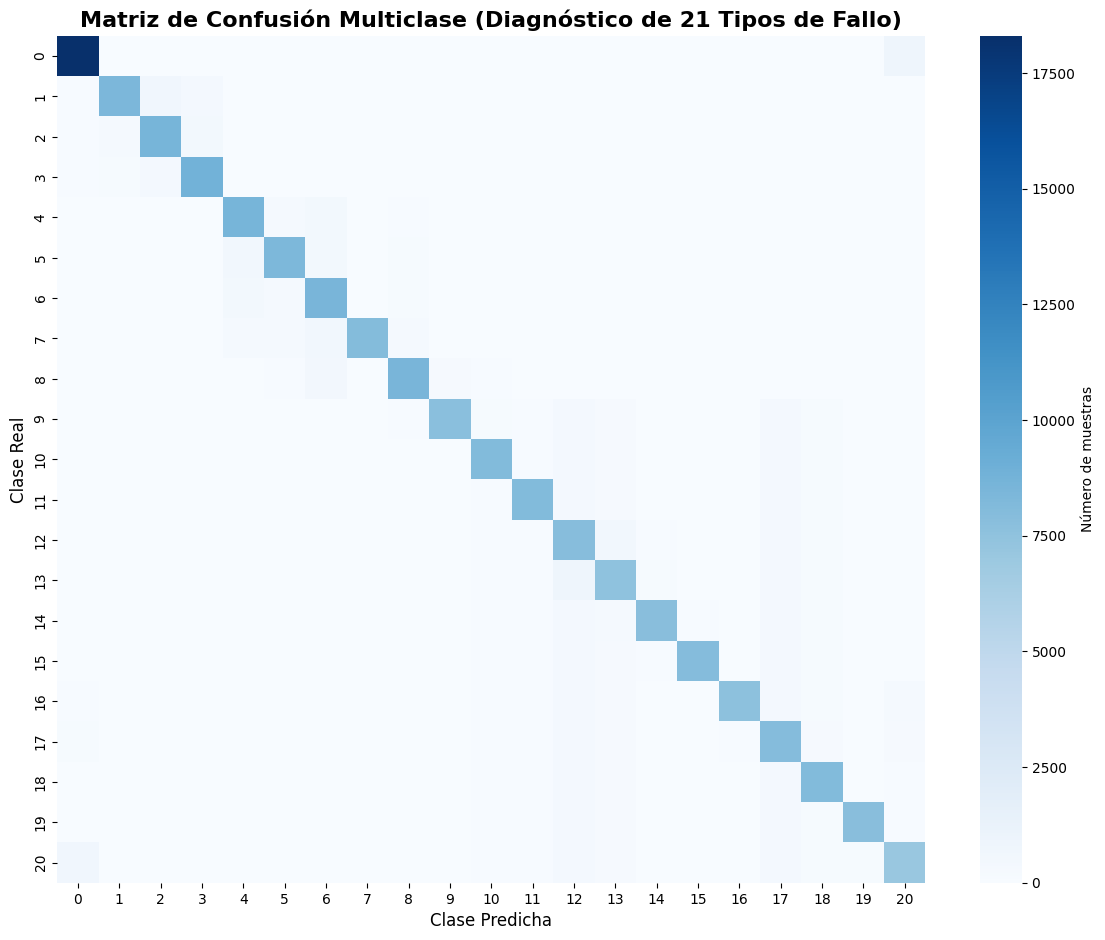

In [12]:
# ==============================================================================
# MODELO 3: EVALUACIÓN Y ANÁLISIS DE RESULTADOS
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparación de datos de test
df_test = pd.read_csv("DatasetProcesado/TEP_features_test.csv")
X_test_red = df_test[top_features].astype(np.float32)
y_test = df_test["faultNumber"]

# Transformar usando el scaler que aprendió del entrenamiento del Modelo 3
X_test_scaled = scaler3.transform(X_test_red)

# 2. Predicciones
print("Calculando predicciones para 211,200 muestras...")
y_pred3 = model3.predict(X_test_scaled)

# 3. Impresión de métricas 
print("\n--- MÉTRICAS DE DESEMPEÑO - MODELO 3 (MULTICLASE) ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred3):.4f}")
print(f"Precision: {precision_score(y_test, y_pred3, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred3, average='weighted', zero_division=0):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred3, average='weighted', zero_division=0):.4f}")

# 4. Reporte detallado por clase
print("\nClassification Report (21 Clases de Fallo):")
print(classification_report(y_test, y_pred3, digits=4))

# 5. Visualización de la Matriz de Confusión (Azul Clarito a Azul Oscuro)
cm = confusion_matrix(y_test, y_pred3)
plt.figure(figsize=(14, 11))

# Usamos cmap='Blues' para la escala solicitada
sns.heatmap(
    cm, 
    annot=False,    
    cmap='Blues',   
    fmt='d', 
    cbar_kws={'label': 'Número de muestras'}
)

plt.title("Matriz de Confusión Multiclase (Diagnóstico de 21 Tipos de Fallo)", fontsize=16, fontweight='bold')
plt.xlabel("Clase Predicha", fontsize=12)
plt.ylabel("Clase Real", fontsize=12)
plt.show()

## Conclusiones
El modelo ha alcanzado una accuracy un poco menor que los otros modelos, pero aun así son unos buenos resultados (85.32%). Aunque los resultados son peores que los de los modelos anteriores, son muy buenos considerando la complejidad de clasificar 21 clases.

La clase 0 (sin fallo) se detecta con una precisión del 92.79% y un recall del 95.35%, mientras que las demás clases varían desde el 74% de recall en la clase 20 hasta un excelente 92% de recall en la clase 3.

Al observar la matriz de confusión, se nota una diagonal muy marcada, lo que confirma que el modelo identifica correctamente la gran mayoría de los tipos de fallos. La celda más marcada es la de no fallo (clase 0). Aunque algunos fallos se confunden entre sí por tener señales muy parecidas, la fuerza de la diagonal demuestra que con el 75% de la importancia el modelo captura perfectamente el comportamiento del sistema.

# Modelo 4: Detección de anomalías con Isolation Forest

## Objetivo del modelo

El objetivo de este modelo es detectar comportamientos anómalos en el sistema TEP sin necesidad de etiquetas durante el entrenamiento. A diferencia de los modelos supervisados, este enfoque busca identificar desviaciones respecto al comportamiento normal del proceso, lo que permite detectar fallos incipientes, situaciones anómalas o estados no habituales incluso cuando no se dispone de un tipo de fallo claramente definido.

Este tipo de modelo es especialmente útil como sistema de vigilancia continua, ya que puede señalar anomalías antes de que se manifiesten como fallos.

In [13]:
import pandas as pd
import numpy as np
import bentoml
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

def entrenar_modelo4():
    # 1. Carga y filtrado de datos normales para entrenamiento
    df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
    
    # Isolation Forest se entrena mejor solo con datos normales (clase 0)
    df_train_normal = df_train[df_train["fault_present"] == 0]
    
    # Usamos las top_features y convertimos a float32 para ahorrar memoria
    X_train = df_train_normal[top_features].astype(np.float32)
    
    # 2. Escalado específico
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # 3. Entrenamiento de Isolation Forest
    # n_jobs=1 para evitar errores de memoria en Windows
    iso = IsolationForest(
        n_estimators=100,
        contamination=0.01, 
        random_state=42,
        n_jobs=1
    )
    
    print(f"Entrenando Isolation Forest con {len(X_train)} muestras normales...")
    iso.fit(X_train_scaled)

    # 4. REGISTRO EN BENTOML
    bentoml.sklearn.save_model(
        "tep_model4",
        iso,
        metadata={
            "top_features": top_features,
            "scaler_mean": scaler.mean_.tolist(),
            "scaler_scale": scaler.scale_.tolist(),
            "type": "Anomaly Detection (Unsupervised)",
            "trained_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    )

    # 5. GUARDAR LOCALMENTE (Backup para Streamlit)
    os.makedirs("modelos", exist_ok=True)
    joblib.dump(
        {
            "model": iso,
            "scaler": scaler,
            "features": top_features
        },
        "modelos/isolation_forest.pkl"
    )
    print("Modelo y scaler guardados en 'modelos/isolation_forest.pkl'")

    return iso, scaler

In [14]:
# 1. Ejecutar entrenamiento
iso_model, iso_scaler = entrenar_modelo4()
print("Modelo 4 (Isolation Forest) optimizado y registrado en BentoML.")

# 2. Preparación de test 
df_test = pd.read_csv("DatasetProcesado/TEP_features_test.csv")
X_test_red = df_test[top_features].astype(np.float32)
y_true = df_test["fault_present"]

# Transformar test con el scaler del modelo 4
X_test_scaled = iso_scaler.transform(X_test_red)

# 3. Predicciones
# Isolation Forest devuelve: 1 para Normal, -1 para Anomalía
y_pred_raw = iso_model.predict(X_test_scaled)

# Mapeo a nuestro estándar: 1 si es anomalía (-1), 0 si es normal (1)
y_pred_if = [1 if p == -1 else 0 for p in y_pred_raw]

# 4. Cálculo de métricas
print("\n--- MÉTRICAS ISOLATION FOREST (DETECCIÓN DE ANOMALÍAS) ---")

# El score de decisión (negativo de la función de anomalía) para el ROC-AUC
decision_scores = -iso_model.decision_function(X_test_scaled)
print(f"ROC-AUC Score: {roc_auc_score(y_true, decision_scores):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_if, digits=4))

print("\nMatriz de Confusión (Valores brutos):")
print(confusion_matrix(y_true, y_pred_if))

Entrenando Isolation Forest con 10000 muestras normales...
Modelo y scaler guardados en 'modelos/isolation_forest.pkl'
Modelo 4 (Isolation Forest) optimizado y registrado en BentoML.

--- MÉTRICAS ISOLATION FOREST (DETECCIÓN DE ANOMALÍAS) ---
ROC-AUC Score: 0.9169

Classification Report:
              precision    recall  f1-score   support

           0     0.2082    0.9695    0.3428     19200
           1     0.9952    0.6313    0.7725    192000

    accuracy                         0.6620    211200
   macro avg     0.6017    0.8004    0.5577    211200
weighted avg     0.9236    0.6620    0.7335    211200


Matriz de Confusión (Valores brutos):
[[ 18614    586]
 [ 70791 121209]]


## Conclusiones

El modelo Isolation Forest ha alcanzado un ROC-AUC de 0.9169, lo que demuestra que puede distinguir estados anómalos sin haber necesitado etiquetas de fallo durante su entrenamiento.

Con una precisión del 99.52%, el modelo garantiza que casi cada anomalía detectada es un fallo real, minimizando falsas alarmas. Además, identifica autónomamente el 63.13% de los fallos (121,209 casos) basándose solo en el estado normal, con apenas 586 falsos positivos.

A diferencia de los modelos supervisados anteriores, este enfoque no supervisado aporta un valor crítico al poder identificar fallos nuevos.

# Modelo 5: Detección de anomalías con autoencoder

## Objetivo del modelo
El objetivo de este modelo es detectar comportamientos anómalos en el proceso TEP sin necesidad de conocer explícitamente el tipo de fallo. Para ello, se entrena un autoencoder solamente con datos normales, de forma que aprenda el patrón de funcionamiento correcto del sistema.
Cuando el modelo encuentra muestras cuya reconstrucción es significativamente peor, estas se consideran anomalías, lo que permite identificar fallos conocidos y potenciales fallos no vistos previamente. Este enfoque es útil como sistema de detección temprana y general de anomalías.

In [15]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def entrenar_modelo5():
    # 1. Carga de datos (Solo normales para aprender el patrón base)
    df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
    df_train_normal = df_train[df_train["fault_present"] == 0].copy()

    # Usamos float32 para compatibilidad total con TensorFlow y ahorro de RAM
    X_train = df_train_normal[top_features].astype(np.float32)
    
    # Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.fillna(0))

    # 2. Arquitectura de la Red Neuronal
    input_dim = len(top_features)
    autoencoder = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='selu', kernel_regularizer=l2(1e-5)),
        Dropout(0.1),
        Dense(32, activation='selu'),
        Dense(64, activation='selu'),
        Dense(input_dim, activation='linear')
    ])

    autoencoder.compile(optimizer="adam", loss="mse")
    
    # 3. Entrenamiento silencioso
    print("Entrenando Red Neuronal Autoencoder...")
    autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=50, 
        batch_size=256, 
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    # 4. Cálculo del Umbral (Threshold)
    # Definimos el umbral en el percentil 98 del error de reconstrucción en datos normales
    recon_train = autoencoder.predict(X_train_scaled, verbose=0)
    mse_train = np.mean(np.square(X_train_scaled - recon_train), axis=1)
    threshold = np.percentile(mse_train, 98)

    # 5. Registro en BentoML (Usando el tag 'tensorflow' que espera tu service.py)
    print("Registrando modelo en BentoML store...")
    bentoml.tensorflow.save_model(
        "tep_model5",
        autoencoder,
        metadata={
            "top_features": top_features,
            "scaler_mean": scaler.mean_.tolist(),
            "scaler_scale": scaler.scale_.tolist(),
            "threshold": float(threshold),
            "trained_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    )

    # 6. GUARDAR LOCALMENTE PARA STREAMLIT
    os.makedirs("modelos", exist_ok=True)
    joblib.dump(
        {
            "model": autoencoder,
            "scaler": scaler,
            "threshold": float(threshold),
            "features": top_features
        },
        "modelos/autoencoder_model.pkl"
    )
    print(f"Autoencoder y scaler guardados localmente en 'modelos/autoencoder_model.pkl' con umbral {threshold:.6f}")

    return autoencoder, scaler, threshold

# Ejecutar
ae_model, ae_scaler, ae_threshold = entrenar_modelo5()
print(f"Autoencoder y Scaler guardados. Umbral de detección: {ae_threshold:.6f}")

Entrenando Red Neuronal Autoencoder...
Registrando modelo en BentoML store...


C:\Users\Alba\AppData\Local\Temp\ipykernel_5492\4052434919.py:51: BentoMLDeprecationWarning: `bentoml.tensorflow` is deprecated since v1.4 and will be removed in a future version.
  bentoml.tensorflow.save_model(


INFO:tensorflow:Assets written to: C:\Users\Alba\AppData\Local\Temp\tmpke14u0xkbentoml_model_tep_model5\assets


INFO:tensorflow:Assets written to: C:\Users\Alba\AppData\Local\Temp\tmpke14u0xkbentoml_model_tep_model5\assets


Autoencoder y scaler guardados localmente en 'modelos/autoencoder_model.pkl' con umbral 0.180983
Autoencoder y Scaler guardados. Umbral de detección: 0.180983


In [17]:
# 1. Preparación de test
df_test = pd.read_csv("DatasetProcesado/TEP_features_test.csv")
X_test_raw = df_test[top_features].astype(np.float32).fillna(0)
y_true = df_test["fault_present"]

# Transformar test
X_test_scaled = ae_scaler.transform(X_test_raw)

# 2. Cálculo de Error de Reconstrucción (MSE)
recon_test = ae_model.predict(X_test_scaled, verbose=0)
mse_test = np.mean(np.square(X_test_scaled - recon_test), axis=1)

# 3. Clasificación: 1 si el error supera el umbral, 0 si no
y_pred_ae = (mse_test > ae_threshold).astype(int)

print("\n--- MÉTRICAS AUTOENCODER (DEEP LEARNING) ---")
print(f"ROC-AUC Score: {roc_auc_score(y_true, mse_test):.4f}")
print(f"Accuracy: {accuracy_score(y_true, y_pred_ae):.4f}")

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_ae, digits=4))

print("\nMatriz de Confusión (Valores brutos):")
print(confusion_matrix(y_true, y_pred_ae))


--- MÉTRICAS AUTOENCODER (DEEP LEARNING) ---
ROC-AUC Score: 0.8627
Accuracy: 0.8156

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.3155    0.8795    0.4644     19200
           1     0.9853    0.8092    0.8886    192000

    accuracy                         0.8156    211200
   macro avg     0.6504    0.8443    0.6765    211200
weighted avg     0.9244    0.8156    0.8501    211200


Matriz de Confusión (Valores brutos):
[[ 16886   2314]
 [ 36630 155370]]


## Comparación de modelos

| Modelo | Tipo de tarea | Algoritmo | Métricas clave | Observaciones |
|--------|---------------|-----------|----------------|---------------|
| Modelo 1 | Clasificación binaria (fallo presente) | Random Forest | Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0, ROC-AUC=1.0 | Dataset desbalanceado (1:10), pero predice ambas clases correctamente. Ideal para detección inmediata. |
| Modelo 2 | Predicción de fallos futuros (HORIZON=10) | Random Forest (class_weight='balanced') | Accuracy≈1.0, Precision≈1.0, Recall clase 1≈1.0, Recall clase 0≈0.96, ROC-AUC≈0.9996 | Anticipa fallos con alto recall; algunos falsos positivos manejables. Muy útil para alerta temprana. |
| Modelo 3 | Clasificación multiclase (tipo de fallo) | Random Forest | Accuracy=0.88, Macro F1≈0.89, Recall 0-19: 0.81–1.0, Clase 20: Prec=0.36, Rec=0.99 | Identifica correctamente la mayoría de fallos; algunas clases se confunden por similitud en señales. Clase 20 con muchos falsos positivos. |
| Modelo 4 | Detección de anomalías (unsupervised) | Isolation Forest | Accuracy=0.46, Precision clase 0=0.14, Recall clase 0=0.95, Precision clase 1=0.99, Recall clase 1=0.41, ROC-AUC=0.84 | Detector conservador de anomalías; detecta bien normales, pero solo 41% de fallos reales. No reemplaza modelos supervisados. |
| Modelo 5 | Detección de anomalías (autoencoder) | Deep Autoencoder | MSE > umbral 98 percentil, ROC-AUC ≈ alto | Aprende patrones normales; destaca anomalías no supervisadas. Más flexible que Isolation Forest y permite ajuste de umbral según criticidad. |


Con esta tabla comparativa podemos ver como los modelos tienen distintos objetivos. Los modelos supervisados (1-3) tienen buenos resultados a la hora de predecir fallos y clasificación multiclase. Por otro lado, los modelos no supervisados (4-5) sirven para detectar anomalías sin etiquetas, esto hace que sean muy útiles para la detección temprana de comportamientos anomalos.

En cuanto a la elección del mejor modelo, en este caso no existe un modelo mejor que otro. Todos los modelos son importantes porque cada uno hace una tarea específica a la hora de monitorear y de realizar un mantenimiento predictivo. En general, se complementan ya que cada uno aporta su valor segun la tarea que se quiera hacer.